<a href="https://colab.research.google.com/github/Bhawana34385/Music-Generation-Using-Deep-Learning/blob/main/music_genertaion_using_deep_learning_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#library for understanding music
from music21 import *

In [ ]:
#defining function to read MIDI files
def read_midi(file):

    print("Loading Music File:",file)

    notes=[]
    notes_to_parse = None

    #parsing a midi file
    midi = converter.parse(file)

    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:

        #select elements of only piano
        if 'Piano' in str(part):

            notes_to_parse = part.recurse()

            #finding whether a particular element is note or a chord
            for element in notes_to_parse:

                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))

                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [ ]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path="/content/drive/MyDrive/music_data/"

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

FileNotFoundError: ignored

In [ ]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

NameError: ignored

(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

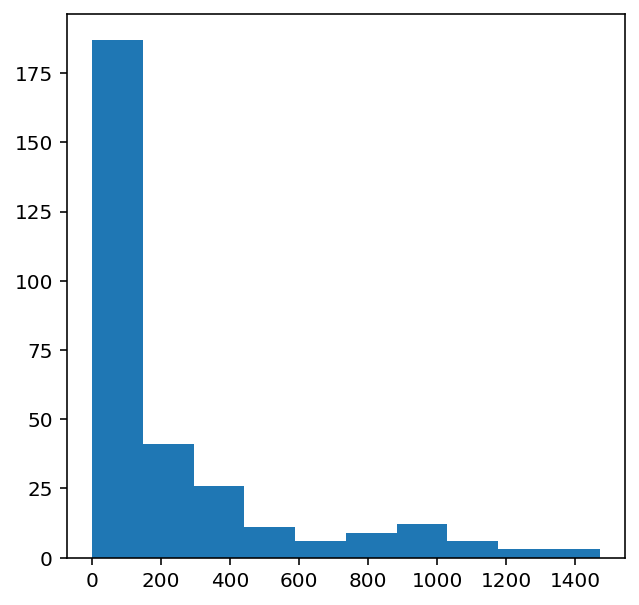

In [ ]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [ ]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [ ]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)
    new_music.append(temp)

new_music = np.array(new_music)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):

        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]

        x.append(input_)
        y.append(output)

x=np.array(x)
y=np.array(y)

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [ ]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)

x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y))
y_seq=np.array([y_note_to_int[i] for i in y])

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()

#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True))

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

#model.add(Conv1D(256,5,activation='relu'))
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           16700     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [ ]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [ ]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
403/403 [==============================] - ETA: 0s - loss: 4.3355
Epoch 1: val_loss improved from inf to 4.06580, saving model to best_model.h5
403/403 [==============================] - 41s 98ms/step - loss: 4.3355 - val_loss: 4.0658
Epoch 2/50
403/403 [==============================] - ETA: 0s - loss: 3.7763
Epoch 2: val_loss improved from 4.06580 to 3.82185, saving model to best_model.h5
403/403 [==============================] - 39s 98ms/step - loss: 3.7763 - val_loss: 3.8218
Epoch 3/50
403/403 [==============================] - ETA: 0s - loss: 3.6029
Epoch 3: val_loss improved from 3.82185 to 3.66396, saving model to best_model.h5
403/403 [==============================] - 37s 92ms/step - loss: 3.6029 - val_loss: 3.6640
Epoch 4/50
403/403 [==============================] - ETA: 0s - loss: 3.4734
Epoch 4: val_loss improved from 3.66396 to 3.54483, saving model to best_model.h5
403/403 [==============================] - 39s 97ms/step - loss: 3.4734 - val_loss: 3.5448
Epoc

In [ ]:
#loading best model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/model_save")


In [ ]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(predictions)

[115, 125, 141, 53, 115, 121, 115, 115, 115, 50]


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in predictions]

In [ ]:
def convert_to_midi(prediction_output):

    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:

        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:

                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        # pattern is a note
        else:

            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [ ]:
convert_to_midi(predicted_notes)